# Scraping the Gitcoin Grants donations network for a Kumu visualization

Danilo Lessa Bernardineli (danilo.bernardineli@usp.br)

---

On this notebook, we'll create an create an spreadsheet on Kumu's format so that we can visualize the relationships in the network generated by Gitcoin Grains donations.

This is done through the following steps:

1. Scraping the information for all existing Grants
2. Parse them and generate links for the URIs associating grants with Gitcoin members
3. Scrape all the grant donors URIs
4. Parse it so that we retrieve a list of donors for each existing

## 0 - dependences and constants

In [ ]:
%load_ext autotime

In [2]:
# External dependences
import requests as req
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Standard library dependences
import json
from multiprocessing.pool import ThreadPool
import random

time: 2.26 s


In [3]:
OVERVIEW_URI = 'https://gitcoin.co/grants/cards_info?limit=10000'
CONTRIBUTORS_URI_TEMPLATE = 'https://gitcoin.co/grants/{id}/{slug}?tab=contributors'
CONTRIBUTORS_SELECTOR = '.grant-profile'

time: 1.19 ms


## 1 - scraping and parsing the grants

In [4]:
# Retrieve the grants informations
r = req.get(OVERVIEW_URI)
with open('data/grants.json', 'wb') as fid:
    fid.write(r.content)
    
# Parse and get the grants key
overview_output: dict = json.loads(r.content)
grants: list = overview_output['grants']

time: 13.3 s


## 2 - scraping and parsing the donors

In [5]:
def scrap_grant_contributors(grant: dict) -> list:
    """
    Returns a list of contributors given by the input grant dictionary
    """
    # Get the grant contributors HTML source
    contributors_uri = CONTRIBUTORS_URI_TEMPLATE.format(**grant)
    r = req.get(contributors_uri)
    contributors_html = r.content
    
    # Parse and extract the profiles
    soup = BeautifulSoup(contributors_html)
    raw_profiles = soup.select(CONTRIBUTORS_SELECTOR)
    
    # Cleanup and return
    profiles = [p.text for p in raw_profiles]
    return profiles

# Scrap the contributors for all grants in parallel
with ThreadPool() as pool:
    output = tqdm(pool.imap(scrap_grant_contributors, 
                            grants),
                  desc='Scraping grants',
                  total=len(grants))
    ordered_grant_profiles = list(output)
    
# Create an dictionary mapping a slug to a list of contributors
grant_profiles = {grant['slug']: ordered_grant_profiles[i]
                  for i, grant 
                  in enumerate(grants)}    



time: 2min 6s


## 3 - Creating a NetworkX graph and visualizing a sample of it

In [6]:
# Generate NetworkX and print the amount of elements
G = nx.Graph(grant_profiles)
print(len(G.edges))

17920
time: 95 ms


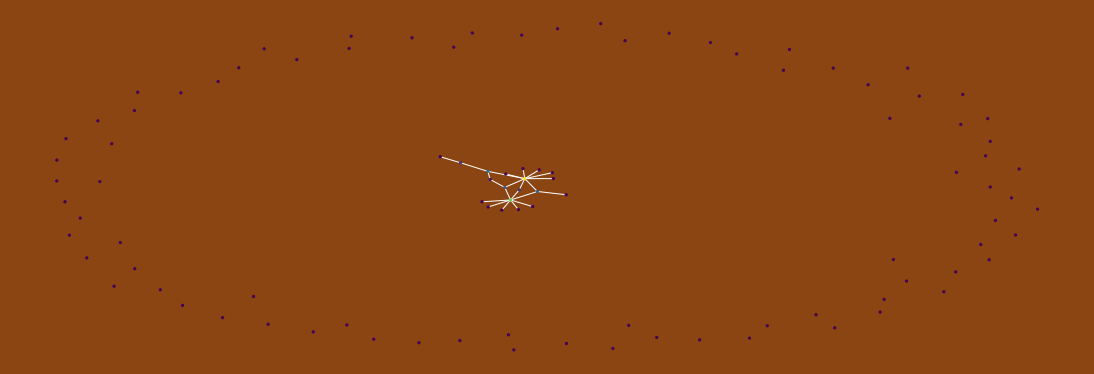

time: 681 ms


In [7]:
# Get 100 random nodes of about ~17k
k = 100
sampled_nodes = random.sample(G.nodes, k)
graph = G.subgraph(sampled_nodes)

# Color by the betweenness centrality
centrality = nx.betweenness_centrality(graph)
colors = list(centrality.values())

# Plot figure
fig = plt.figure(figsize=(15, 5))
nx.draw(graph, 
        node_size=5,
        node_color=colors,
        edge_color='white')
fig.set_facecolor('SaddleBrown')

## 4 - Parsing and saving the graph into a spreadsheet format

In [8]:
# Get the graph edges and rename columns so that Kumu can parse
edges = (nx.to_pandas_edgelist(G)
           .rename(columns={'source': 'From',
                            'target': 'To'}))

# Same thing for the nodes
nodes = (pd.DataFrame(G.nodes)
           .rename(columns={0: 'label'})
        )

# Set the element type
nodes['Element-Type'] = 'Colaborator'
nodes.loc[nodes.label.isin(grant_profiles.keys()), 'Element-Type'] = 'Grant'

# Write everything to a excel spreadsheets
writer = pd.ExcelWriter('data/kumu-data.xlsx', engine='xlsxwriter')
nodes.to_excel(writer, sheet_name='Elements', index=False)
edges.to_excel(writer, sheet_name='Connections', index=False)
writer.save()


time: 2.81 s
